In [6]:
# %matplotlib widget

class car:
    def __init__(self,name,mass,cgheight,wheelbase,frontaxledistance,rearaxledistance,mu,wheelradius,gearratio) -> None:
        self.name = name
        self.m = mass
        self.cgh = cgheight
        self.l = wheelbase
        self.b = frontaxledistance
        self.c = rearaxledistance
        self.v = 0
        self.mu = mu
        self.r = wheelradius
        self.gr = gearratio
        self.nf = mass * 9.8 * (rearaxledistance/wheelbase)
        self.nr =mass * 9.8 * (frontaxledistance/wheelbase)
        self.cd = 0.7
        self.cl = 0.8
        self.area = 1.0
        self.drivelineloss = 0.95
        assert self.nf + self.nr == self.m * 9.8, f"{self.nf} {self.nr}, {self.m}"
        
    def __str__(self) -> str:
        return f"name: {self.name} mass: {self.m}kg cgheight: {self.cgh}m wheelbase: {self.l}m\n front distance: {self.b:.2f}m rear: {self.c:.2f}m\nStatic front axle normal force: {self.nf:.2f}N rear: {self.nr:.2f}N\n friction coeff: {self.mu} tire radius: {self.r} ratio: {self.gr}"
        
    def calc_normal_force_rear(self,acceleration,weight_transfer=True):
        g = 9.8
        if not weight_transfer:
            acceleration = 0
        nr = self.m / self.l * (g * self.b + acceleration * self.cgh)
        # nr = (self.m * g * self.b + acceleration * self.cgh)/self.l
        return nr
    
    def calc_normal_force_front(self,acceleration,weight_transfer=True):
        g = 9.8
        if not weight_transfer:
            acceleration=0
        nf = self.m / self.l * (g * self.c - acceleration * self.cgh)
        self.nf = nf
        return self.nf
    
    def calc_velocity(self,acceleration,time):
        initial_v = self.v
        v = initial_v + acceleration * time
        self.v = v
        return self.v
    
    def calc_aero_forces(self,v,rho=1.226):
        drag = 0.5 * (v**2) * rho * self.cd * self.area
        downforce = 0.5 * (v ** 2) * rho * self.cl * self.area
        return downforce,drag
    
    


In [7]:
from motor import Motor,EMRAX_MOTORS
from tire import tire_utils
from tire.tire_solver import Tire,LC0
from battery import batteryPack,batt_models
r20 = Tire(tire_utils.H_R20_18X6_7,.6)
class accel_solver:
    def __init__(self,car:car,motor:Motor = EMRAX_MOTORS[0],tire: Tire = LC0,accumulator:batteryPack=batt_models.energus300v) -> None:
        self.car = car
        self.motor = motor
        self.accumulator = accumulator
        self.time = 0
        self.last_nr = None
        self.acceleration = 0
        self.distance = 0
        self.tire = tire
        
    def calc_motor_battery_instantaneous_power(self, rpm: int, torque: float, power_limit:float = 80000,efficiency1:float = 0.95, efficiency2:float = 0.95, max_iterations: int = 100, rolling_average_window: int = 20, convergence_threshold: float = 5.0):
        """Calculate the instantaneous power of a motor with a batteryPack as the source
        Dynamically sags battery pack and recalculates motor power (since voltage decreases, the available torque may decrease too)

        Args:
            batterypack (batteryPack): battery pack object which will be the power source
            motor (Motor): motor object to calculate power for  
            rpm (int): rpm target for motor
            torque (float): torque target for motor
            power_limit (float, optional): power limit for the accumulator. Defaults to 80000.
            max_iterations (int, optional): maxmimum iteration count to solve. Defaults to 1000.
            rolling_average_window (int, optional): the amount of averages that will be taken to . Defaults to 100.
            convergence_threshold (float, optional): _description_. Defaults to 1.0.

        Returns:
            _type_: _description_
        """
        # get starting state
        current_motor = self.motor
        pack = self.accumulator
        last_voltage = 0
        power_limit = min(power_limit, pack.getMaxPowerOut())

        current_voltage = pack.getInstantaneousVoltage(0)
        if torque * rpm / 9.5488 > (power_limit * efficiency1 * efficiency2):
            torque = (power_limit * efficiency1 * efficiency2) / rpm * 9.5488
            
        id, iq, motortorque, speed, vout = current_motor.get_qd_currents(rpm, torque, current_voltage, powerlim=80000)
        motor_power = motortorque * rpm / 9.5488
        # print(f"Id: {id} Iq: {iq} Motor torque: {motortorque} Rpm: {rpm} Power: {motor_power}W")
        acc_required_power = motor_power / efficiency1 / efficiency2

        voltage_history = []
        iterations = 0
        while (iterations < max_iterations) & (round(last_voltage, 1) != round(current_voltage, 1)):
            last_voltage = current_voltage
            current = acc_required_power / current_voltage
            current_voltage = pack.getInstantaneousVoltage(current)

            id, iq, motortorque, speed, vout = current_motor.get_qd_currents(rpm, torque, current_voltage)
            motor_power = motortorque * rpm / 9.5488
            acc_required_power = motor_power / efficiency1 / efficiency2
            
            voltage_history.append(current_voltage)
            if len(voltage_history) > rolling_average_window:
                voltage_history.pop(0)
                average_voltage = sum(voltage_history) / len(voltage_history)
                # print(f"Last V: {last_voltage:.3f} Current V: {current_voltage:.3f} Id: {id:.3f} Iq: {iq:.3f} Torque: {torque:.3f} Power: {motor_power:.3f} Avg V: {average_voltage:.3f}")

                if abs(average_voltage - current_voltage) < convergence_threshold:
                    # print(f"Converged after {iterations} iterations.")
                    id, iq, motortorque, speed, vout = current_motor.get_qd_currents(rpm, torque, average_voltage)
                    motor_power = motortorque * rpm / 9.5488
                    acc_required_power = motor_power / efficiency1 / efficiency2
                    current = acc_required_power / average_voltage
                    current_voltage = average_voltage
                    break

            iterations += 1

        if iterations == max_iterations:
            print(f"Warning: Maximum number of iterations reached without convergence. {current_motor.name} {rpm} {torque}")
            print(f"Average: {average_voltage} Current: {current_voltage} Error: {abs(average_voltage - current_voltage)}")
            print(voltage_history)
            out_v = min(voltage_history)
            id, iq, motortorque, speed, vout = current_motor.get_qd_currents(rpm, torque, out_v)
            motor_power = motortorque * rpm / 9.5488
            acc_required_power = motor_power / efficiency1 / efficiency2
            current = acc_required_power / out_v
            current_voltage = out_v

        return motortorque, acc_required_power, current, current_voltage


    def get_motor_torque(self,rpm,torque,voltage=200):
        Id, Iq, motor_output_torque, wbase, v_max = self.motor.get_qd_currents(rpm, torque, voltage)
        return motor_output_torque
    
    def step(self,time,use_weight_transfer=True,use_tire=False):
        elapsed_t = self.time + time
        veh = self.car
        a_initial = self.acceleration
        v_initial = veh.v
        distance_travelled = v_initial*time
        self.distance+=distance_travelled
        # get normal force on rear axle
        nr = veh.calc_normal_force_rear(a_initial,weight_transfer=use_weight_transfer)
        if self.last_nr is None:
            self.last_nr = nr
        else:
            nr_delta = abs(nr - self.last_nr)
            nr_rate = nr_delta/time # force cahnge per scond
            max_nr_rate = 1_000 # per second
            nr_capped = min(nr,self.last_nr + (max_nr_rate*time))
            print(f"nr_rate: {nr_rate} nr: {nr} nr_capped: {nr_capped}")
            nr = min(nr_capped,nr)
            self.last_nr = nr
        nf = self.car.m * 9.8 - nr
        # nf = veh.calc_normal_force_front(a_initial,weight_transfer=use_weight_transfer)
        # get aero forces
        fdownforce,fdrag = veh.calc_aero_forces(v_initial)
        # assume fdownforce is split the same way as weight is distributed
        applied_downforce_r = fdownforce * veh.b / veh.l
        applied_downforce_f = fdownforce * veh.c / veh.l
        
        # get tractive force limit with aero
        total_nr = nr + applied_downforce_r
        total_nf = nf + applied_downforce_f
        print(f"total downforce: {fdownforce:.2f}N\n normal force front: {nf:.2f} df f: {applied_downforce_f:.2f} nf_total: {total_nf:.2f}")
        print(f"normal force rear: {nr:.2f}N df r: {applied_downforce_r:.2f} ftotal: {total_nr:.2f}N")

        # Static coeff calc starts here
        wheelrpm_initial = v_initial * 30 / (3.14 * veh.r)
        motorrpm_initial = wheelrpm_initial * veh.gr
        slipr = None
        if use_tire == False:
            frearmax = (total_nr) * veh.mu
            # calculate the rear torque based on motor as power source:
            
            desired_torque = frearmax * veh.r / veh.gr
            motor_output_torque = self.get_motor_torque(motorrpm_initial,desired_torque)
            motor_output_torque,accpwr,current,voltage = self.calc_motor_battery_instantaneous_power(motorrpm_initial,desired_torque)
            print(f"FREARMAX: {frearmax} MOTOR TORQUE: {motor_output_torque}")
            # let driving force be the min of motor torque or the grip limit
            frear = min(frearmax,(motor_output_torque * self.car.drivelineloss) * veh.gr / veh.r)
            
            ffront = (total_nf) * veh.mu
        # Ends here
        else:
            # Front wheel stuff:
            ffront = 0
            # Find max motor torque:
            max_torque = 300 # just always try to get a shitton of force from the tire solver
            max_wheel_torque = (max_torque * veh.gr / veh.r)/2 # two driven wheels
            fz = total_nr/2 # Split rear axle normal force between two wheels
            slipr,_,achieved_torque=self.tire.s_r(f_z=fz,s_a=0,v_avg=wheelrpm_initial,fx_target=max_wheel_torque,i_a=0,upper=1.0,lower=-1.0)
            achieved_torque *= self.tire.scaling_factor
            
            # Recalculate motor torque
            motor_torque_request = achieved_torque/veh.gr * veh.r * 2
            motor_torque_achieved = self.get_motor_torque(motorrpm_initial,motor_torque_request)
            motor_torque_achieved,accpwr,current,voltage = self.calc_motor_battery_instantaneous_power(motorrpm_initial,motor_torque_request)

            motor_torque_achieved *= self.car.drivelineloss
            final_torque = motor_torque_achieved * veh.gr / veh.r
            print(f"Motor torque request: {motor_torque_request} motor achieved: {motor_torque_achieved}")
            print(f"fz: {fz} fx: {achieved_torque} fx/fz: {achieved_torque/fz}")
            frear = achieved_torque*2 # double it
            print(f"Max Tire: {achieved_torque} @ Motor: {motor_torque_request} Achieved: {motor_torque_achieved}\n At the wheel: {final_torque} Slip: {slipr} Fz: {fz}")
            frear = final_torque
            
            
        ftotal = frear - fdrag
        mph = v_initial * 3.6 /  1.609
        
        # get acceleration from force
        a_new = ftotal / veh.m
        # get velocity
        v_new = veh.calc_velocity(a_new,time)
        # update car
        self.car.v = v_new
        mph = v_new * 3.6 /  1.609
        wheelrpm = v_new * 30 / (3.14 * veh.r)
        motorrpm = wheelrpm * veh.gr
        print('====')
        # print(f'motor torque: {frear * veh.r / veh.gr:.2f} wheel torque: {frear} slip: {slipr} fdrag: {fdrag:.2f} fotal: {ftotal:.2f} mph: {mph:.2f}')
        # print(f"curr time: {elapsed_t:.2f} a: {a_initial:.2f}m/s^2 v: {v_initial:.2f}m/s\n frear:{frear:.2f} \na'{a_new:.2f}m/s^2 v'{v_new:.2f}m/s")
        # update solver
        self.time += time
        self.acceleration = a_new
        return elapsed_t,self.distance,a_new,mph,frear,fdownforce,fdrag,ftotal, wheelrpm,motorrpm,slipr,total_nr,total_nf,voltage,current,accpwr
        



Failed to load fast pacejka, using slow pacejka, you should really compile the fast pacejka its like 3x faster


In [8]:
import pandas as pd


In [9]:
# we want to do 5 secs

use_weight_transfer = True
use_tire = True


def apply_solver_to_df(row, solver: accel_solver, timestep: float = 0.1, use_tire=False, weight_transfer=True):
    timestep = timestep if row['step'] != 0 else 0
    elapsed_t, distance, a_new, mph, frear, fdownforce, fdrag, ftotal, wheelrpm, motorrpm, slip, total_rear_normalforce, total_front_normalforce,voltage,current,accpwr = solver.step(
        timestep, use_weight_transfer=weight_transfer, use_tire=use_tire)
    return pd.Series([elapsed_t, distance, a_new, mph, frear, fdownforce, fdrag, ftotal, wheelrpm, motorrpm, slip, total_rear_normalforce,total_front_normalforce,voltage,current,accpwr])


def find_closest_entry(df, column, target_value):
    # Calculate the absolute difference between each entry in the column and the target value
    absolute_diff = (df[column] - target_value).abs()
    # Find the index of the entry with the smallest absolute difference
    closest_index = absolute_diff.idxmin()
    # Get the value at the closest index
    closest_value = df.loc[closest_index, column]
    return closest_index, closest_value

In [53]:
mass = 285 # kg
cgheight = 0.2751 # m
frontweight = 0.5
wheelbase = 1.61544 # meters   
mu = 1.30
tire_radius = 0.229
final_drive = 3.0 # 208mv final drive guess = 4
use_weight_transfer = True
use_tire = True
motor=EMRAX_MOTORS[1]
# motor.I_dmax = 0
battery = batt_models.energus300v

ksucar = car("ks6e",mass,cgheight,wheelbase,(1-frontweight)*wheelbase,frontweight*wheelbase,mu,tire_radius,final_drive)
print(f"{ksucar.nf} {ksucar.nr}, {ksucar.m}")
print(f"{ksucar.nr * ksucar.mu}")
print(ksucar)
solver = accel_solver(ksucar,motor=motor,accumulator=battery) 
df = pd.DataFrame()
df['step'] = range(0,5000,1)
timestep = 5/(len(df))
print(f"Timestep: {timestep}")

df[['elapsed_t','distance','accel','vel','frear','fdownforce','fdrag','ftot','wheelrpm','motorrpm','slip','rearFz','frontFz','voltage','current','accpwr']] = df.apply(apply_solver_to_df,solver=solver,timestep=timestep,weight_transfer=use_weight_transfer,use_tire=use_tire,axis=1)

1396.5 1396.5, 285
1815.45
name: ks6e mass: 285kg cgheight: 0.2751m wheelbase: 1.61544m
 front distance: 0.81m rear: 0.81m
Static front axle normal force: 1396.50N rear: 1396.50N
 friction coeff: 1.3 tire radius: 0.229 ratio: 3.0
Timestep: 0.001
total downforce: 0.00N
 normal force front: 1396.50 df f: 0.00 nf_total: 1396.50
normal force rear: 1396.50N df r: 0.00 ftotal: 1396.50N
FREARMAX: 1815.45 MOTOR TORQUE: 138.57935
====
nr_rate: 293702.5084497102 nr: 1690.2025084497102 nr_capped: 1397.5
total downforce: 0.00N
 normal force front: 1395.50 df f: 0.00 nf_total: 1395.50
normal force rear: 1397.50N df r: 0.00 ftotal: 1397.50N
FREARMAX: 1816.75 MOTOR TORQUE: 138.67858333333334
====
nr_rate: 292912.8217389691 nr: 1690.4128217389691 nr_capped: 1398.5
total downforce: 0.00N
 normal force front: 1394.50 df f: 0.00 nf_total: 1394.50
normal force rear: 1398.50N df r: 0.00 ftotal: 1398.50N
FREARMAX: 1818.0500116899232 MOTOR TORQUE: 138.77781755899747
====
nr_rate: 292123.1342395938 nr: 1690.6

c:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\motor.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  I_d_fw = -self.Fl / self.Ld + (1/self.Ld) * np.sqrt((v_max**2/w_e**2)-(self.Lq*I_q_fw)**2)


FREARMAX: 1926.0374546107687 MOTOR TORQUE: 147.02085903528868
====
nr_rate: 226573.2381136636 nr: 1708.0732381136636 nr_capped: 1482.5
total downforce: 0.14N
 normal force front: 1310.50 df f: 0.07 nf_total: 1310.57
normal force rear: 1482.50N df r: 0.07 ftotal: 1482.57N
FREARMAX: 1927.3396114713335 MOTOR TORQUE: 147.12025700897846
====
nr_rate: 225783.40589531307 nr: 1708.283405895313 nr_capped: 1483.5
total downforce: 0.14N
 normal force front: 1309.50 df f: 0.07 nf_total: 1309.57
normal force rear: 1483.50N df r: 0.07 ftotal: 1483.57N
FREARMAX: 1928.6417960872916 MOTOR TORQUE: 147.21965710132994
====
nr_rate: 224993.57180450897 nr: 1708.493571804509 nr_capped: 1484.5
total downforce: 0.14N
 normal force front: 1308.50 df f: 0.07 nf_total: 1308.57
normal force rear: 1484.50N df r: 0.07 ftotal: 1484.57N
FREARMAX: 1929.9440085118333 MOTOR TORQUE: 147.31905931640327
====
nr_rate: 224203.73583766332 nr: 1708.7037358376633 nr_capped: 1485.5
total downforce: 0.15N
 normal force front: 1307

In [54]:
index, val = (find_closest_entry(df,'vel',60))
print(f"{val:.2f}mph hit at {df['elapsed_t'][index]:.2f}s")

print(f"{df['fdrag'][index]:.2f}drag hit at {val:.2f}mph")
print(f"{df['fdownforce'][index]:.2f}downforce hit at {val:.2f}mph")

index, val = (find_closest_entry(df,'distance',0.3))
startTime = df['elapsed_t'][index]
print(f"{val:.2f} meters hit at {df['elapsed_t'][index]:.3f}s")


index, val = (find_closest_entry(df,'distance',75+0.301))
endTime = df['elapsed_t'][index]
print(f"{val:.2f} meters hit at {df['elapsed_t'][index]:.3f}s")
if val > 75:
    print(f"{endTime:.3f} - {startTime:.3f} = {endTime-startTime:.3f}s Accel Run")
else:
    print(f"{endTime:.3f} - {startTime:.3f} = {endTime-startTime:.3f}s \n\tTraveled {val:.2f}M, less than Accel Distance")
print("")
print(solver.accumulator)
print(solver.motor.name)
print(f"car summary:\n {str(solver.car)}")


# print(df['distance'].max())

60.00mph hit at 3.96s
308.47drag hit at 60.00mph
352.54downforce hit at 60.00mph
0.30 meters hit at 0.304s
75.30 meters hit at 4.613s
4.613 - 0.304 = 4.309s Accel Run

ENERGUS72s8p 72S 8P, 20.0Ah, Max 302.40V, Nominal 259.2V
228HV
car summary:
 name: ks6e mass: 285kg cgheight: 0.2751m wheelbase: 1.61544m
 front distance: 0.81m rear: 0.81m
Static front axle normal force: 1396.50N rear: 1396.50N
 friction coeff: 1.3 tire radius: 0.229 ratio: 3.0


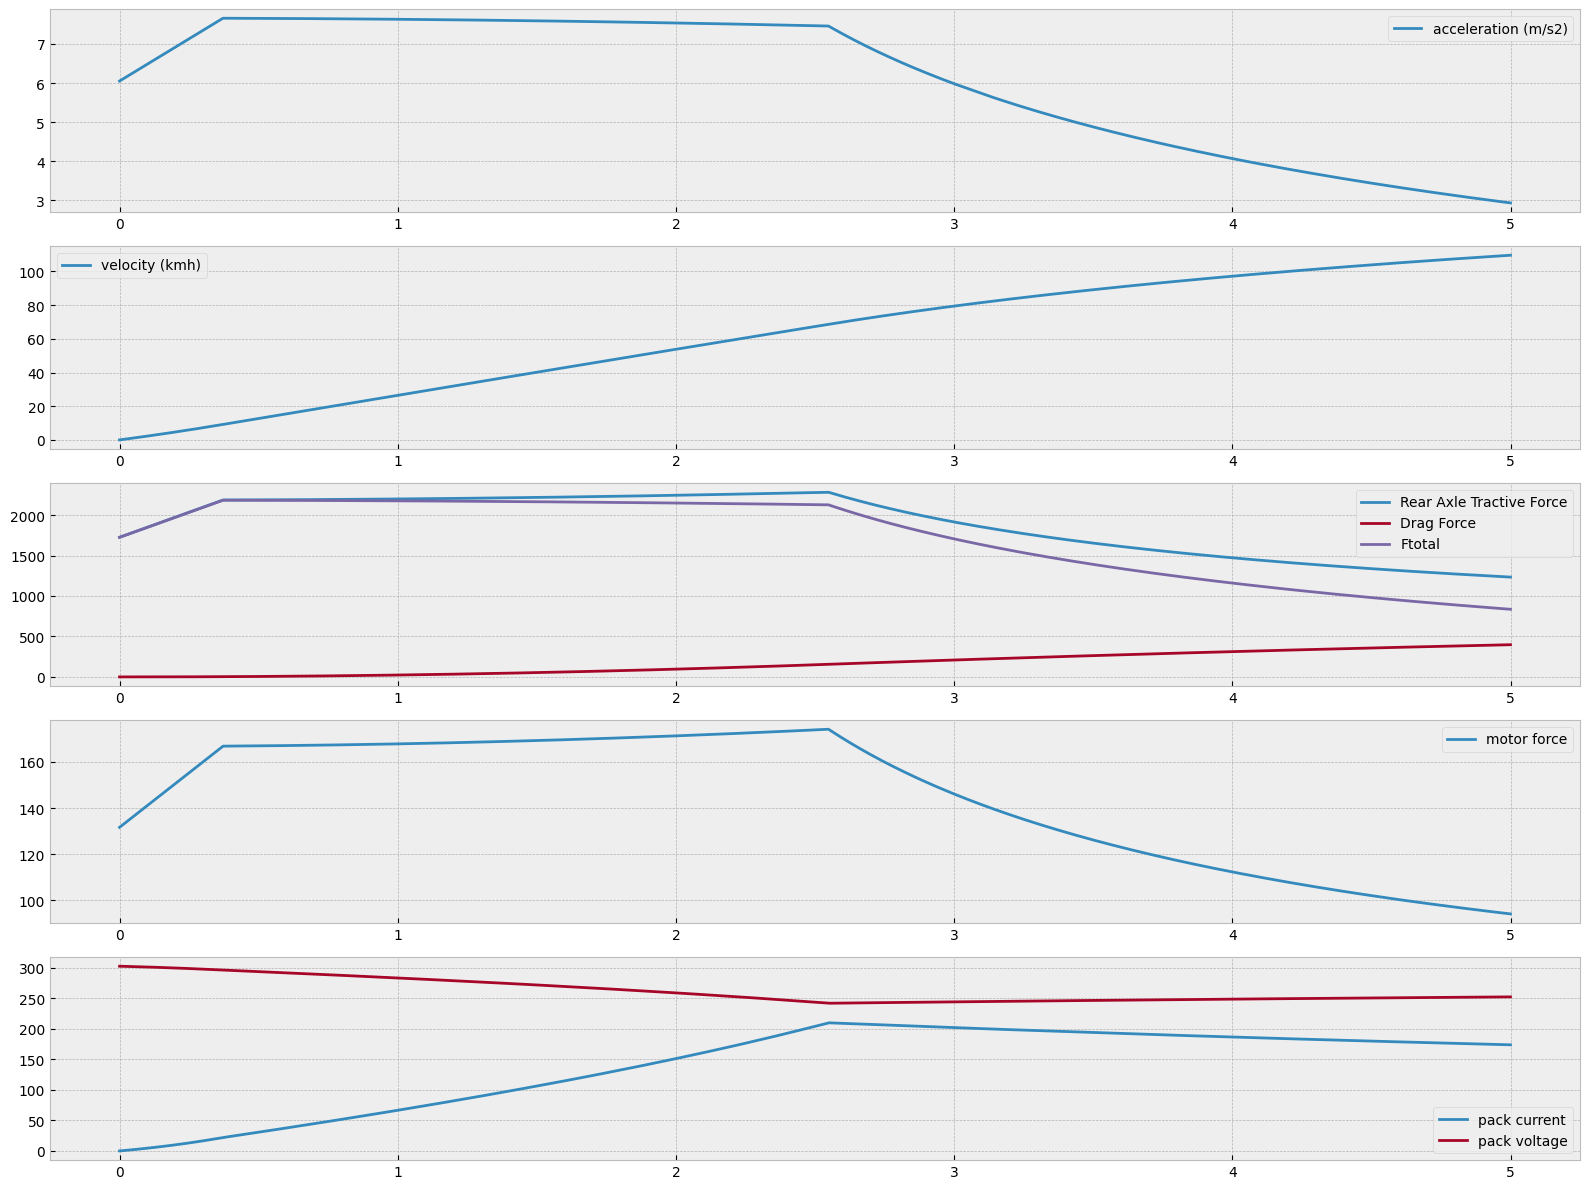

In [55]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize = (16,12))
t = df['elapsed_t']
a = df['accel']
distance = df['distance']
frear = df['frear']
drag = df['fdrag']
total = df['ftot']
motortrq = frear * ksucar.r / ksucar.gr
vel = df['vel'] * 1.609
wheelrpm = df['wheelrpm']
motorrpm = df['motorrpm']
current = df['current']
voltage=df['voltage']
ax1.plot(t,a,label='acceleration (m/s2)')
ax2.plot(t,vel,label='velocity (kmh)')
ax3.plot(t,frear,label="Rear Axle Tractive Force")
ax3.plot(t,drag,label='Drag Force')
ax3.plot(t,total,label='Ftotal')
# ax4.plot(t,wheelrpm,marker='.',label='Wheel RPM')
# ax4.plot(t,motorrpm,marker='.',label='Motor RPM')
# ax4_1 = ax4.twinx()
ax4.plot(t,motortrq,label='motor force')
ax5.plot(t,current,label='pack current')
ax5.plot(t,voltage,label='pack voltage')
for axis in plt.gcf().get_axes():
    # axis.set_xlim((-.01,4.0))
    axis.legend()
plt.tight_layout()

In [56]:
optimumlapsim = pd.read_csv(r'C:\Users\Matthew Samson\source\repos\KS5e-Data-Logging\208mvTestStrip.csv')
optimumlapsim=optimumlapsim.drop(index=0) # weird shit at t=0 for olap
olap_torque = (optimumlapsim['torque'] * (1-(optimumlapsim['tractionControl']/100)))
print(list(optimumlapsim))

['speed', 'elapsedTime', 'elapsedDistance', 'lateralAcceleration', 'longitudinalAcceleration', 'gear', 'gearRatio', 'engineSpeed', 'torque', 'power', 'downForce', 'dragForce', 'tractionControl', 'throttlePosition', 'brakePosition', 'cornerRadius', 'sectorIndex', 'maximumCornerSpeed', 'loadSensitiveLatGrip', 'loadSensitiveLongGrip', 'yawangle', 'yawvelocity', 'yawacceleration', 'xposition', 'yposition', 'trackelevation', 'fz', 'Unnamed: 27']


In [57]:
olap_distance = optimumlapsim['elapsedDistance']
olap_speed = optimumlapsim['speed']
olap_rpm = optimumlapsim['engineSpeed']
olap_accel = optimumlapsim['longitudinalAcceleration']
olap_time = optimumlapsim['elapsedTime']
olap_fz = optimumlapsim['fz']
olap_df = optimumlapsim['downForce']

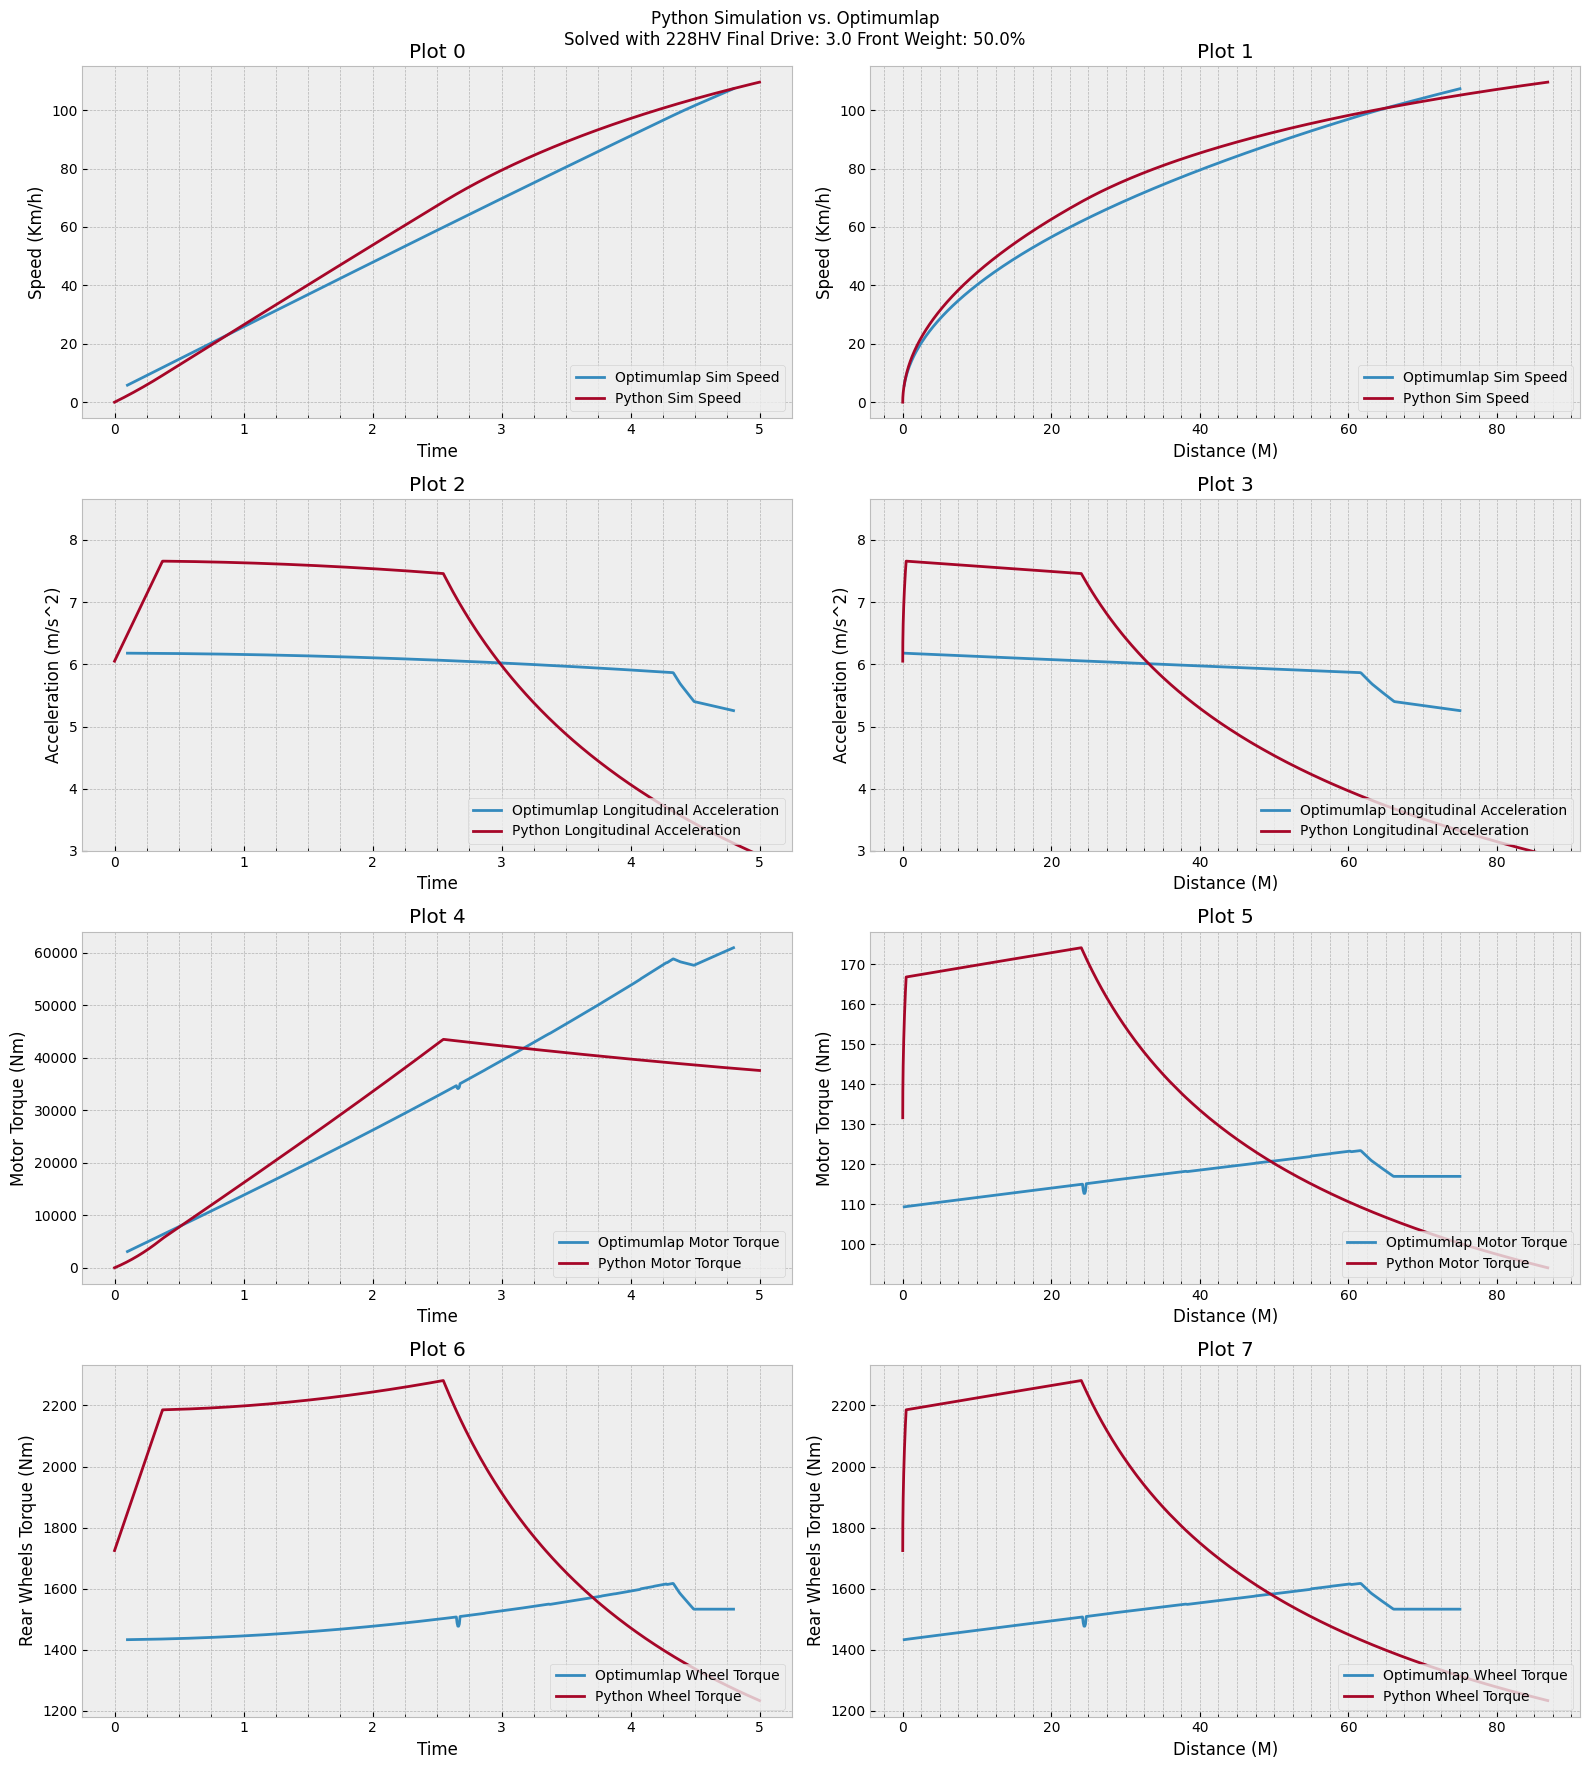

In [63]:
# Plot python solver vs optimumlap accel run

fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2,figsize = (16,18))

ax2.plot(olap_distance,olap_speed,label="Optimumlap Sim Speed")
ax2.plot(distance,vel,label='Python Sim Speed')
ax1.plot(olap_time,olap_speed,label="Optimumlap Sim Speed")
ax1.plot(t,vel,label='Python Sim Speed')
ax1.set_xlabel('Time')
# ax2.plot(t,vel,label='velocity (kmh)')
ax4.plot(olap_distance,olap_accel,label='Optimumlap Longitudinal Acceleration')
ax4.plot(distance,a,label='Python Longitudinal Acceleration')
ax3.plot(olap_time,olap_accel,label='Optimumlap Longitudinal Acceleration')
ax3.plot(t,a,label='Python Longitudinal Acceleration')

ax6.plot(olap_distance,olap_torque,label='Optimumlap Motor Torque')
ax6.plot(distance,motortrq,label='Python Motor Torque')
ax5.plot(olap_time,olap_torque*olap_rpm/9.5488,label='Optimumlap Motor Torque')
ax5.plot(t,motortrq*motorrpm/9.5488,label='Python Motor Torque')

ax8.plot(olap_distance,olap_torque*ksucar.gr/ksucar.r,label='Optimumlap Wheel Torque')
ax8.plot(distance,motortrq*ksucar.gr/ksucar.r,label='Python Wheel Torque')
ax7.plot(olap_time,olap_torque*ksucar.gr/ksucar.r,label='Optimumlap Wheel Torque')
ax7.plot(t,motortrq*ksucar.gr/ksucar.r,label='Python Wheel Torque')

import matplotlib.ticker as ticker
for index,axis in enumerate(plt.gcf().get_axes()):
    plt.gca()
    axis.title.set_text(f'Plot {index}')
    if index % 2 == 0: 
        axis.set_xlabel('Time')
        axis.xaxis.set_minor_locator(ticker.MultipleLocator(.25))
        

    else:
        axis.set_xlabel('Distance (M)')
        axis.xaxis.set_minor_locator(ticker.MultipleLocator(2.5))
    axis.xaxis.grid(True,which='minor')

    if index > 5:
        axis.set_ylabel('Rear Wheels Torque (Nm)')  
    elif index > 3:
        axis.set_ylabel('Motor Torque (Nm)')
    elif index > 1:
        axis.set_ylabel('Acceleration (m/s^2)')
        axis.set_ylim((3,(a.max() + 1)))
    else:
        axis.set_ylabel('Speed (Km/h)')

    axis.legend(loc='lower right')
    
plt.suptitle(f'Python Simulation vs. Optimumlap\nSolved with {solver.motor.name} Final Drive: {solver.car.gr} Front Weight: {solver.car.c/solver.car.l * 100:.1f}%')
plt.tight_layout()
plt.show()


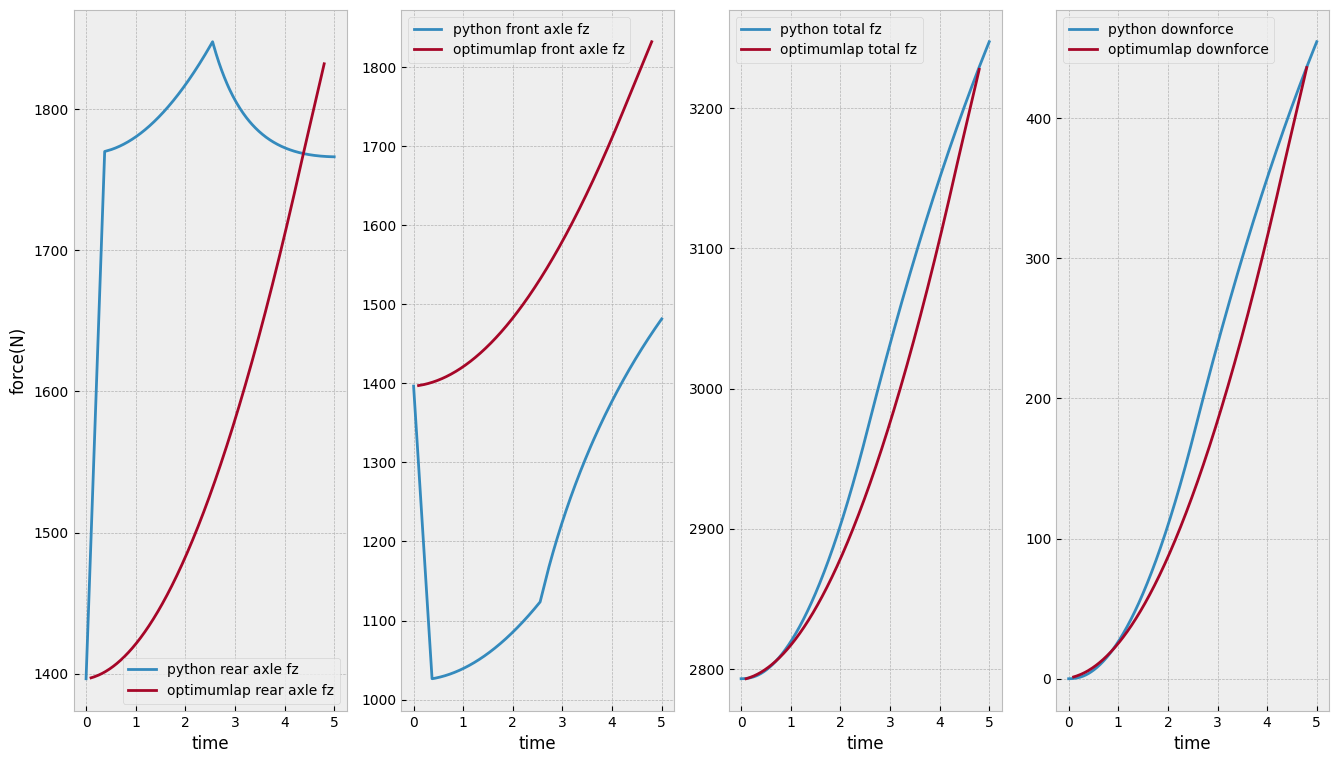

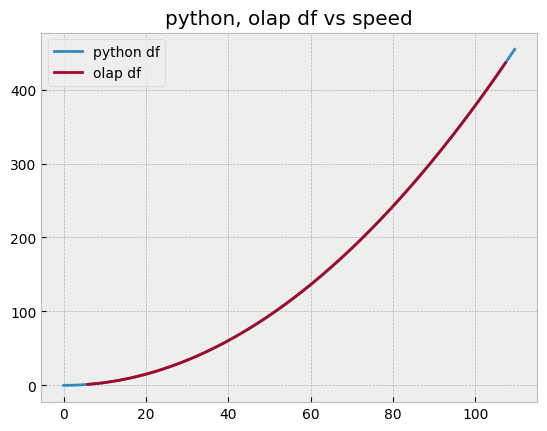

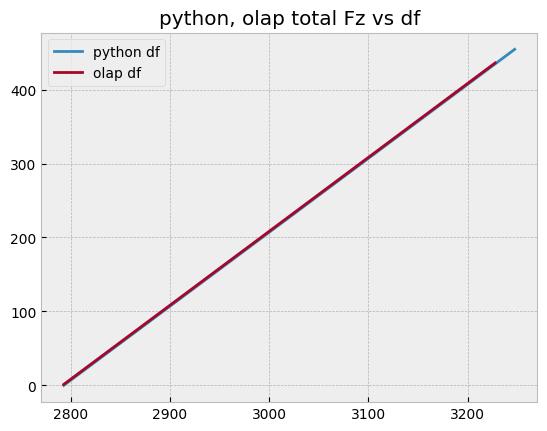

In [59]:
# plt.plot(t,df['rearFz'])
# optimumlap fz/2 vs. python normal force front axle
# vs. rear axle
# Fz (total) vs. sim total
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16.2, 9.1))
ax1.plot(t,df['rearFz'],label='python rear axle fz')
ax1.plot(olap_time,(olap_fz+olap_df)/2,label='optimumlap rear axle fz')
ax1.set_ylabel('force(N)')

ax2.plot(t,df['frontFz'],label='python front axle fz')

ax2.plot(olap_time,(olap_fz+olap_df)/2,label='optimumlap front axle fz')
ax3.plot(t,df['rearFz']+df['frontFz'],label='python total fz')
ax3.plot(olap_time,(olap_fz), label='optimumlap total fz')
ax4.plot(t,df['fdownforce'],label='python downforce')
ax4.plot(olap_time,olap_df,label='optimumlap downforce')
for axis in plt.gcf().get_axes():
    axis.legend()
    axis.set_xlabel('time')
plt.show()
plt.plot(vel,df['fdownforce'],label='python df')
plt.plot(olap_speed,olap_df,label='olap df')
plt.title("python, olap df vs speed")
plt.legend()
plt.show()
plt.plot(df['rearFz']+df['frontFz'],df['fdownforce'],label='python df')
plt.plot(olap_fz,olap_df,label='olap df')
plt.title("python, olap total Fz vs df")
plt.legend()
plt.show()


['D1_Commanded_Torque', 'D2_Torque_Feedback', 'D3_Power_On_Timer', 'D1_Modulation_Index', 'D2_Flux_Weakening_Output', 'D3_Id_Command', 'D4_Iq_Command', 'D1_Digital_Input_1', 'D2_Digital_Input_2', 'D3_Digital_Input_3', 'D4_Digital_Input_4', 'D5_Digital_Input_5', 'D6_Digital_Input_6', 'D7_Digital_Input_7', 'D8_Digital_Input_8', 'D1_VSM_State', 'D2_Inverter_State', 'D3_Relay_1_Status', 'D3_Relay_2_Status', 'D3_Relay_3_Status', 'D3_Relay_4_Status', 'D3_Relay_5_Status', 'D3_Relay_6_Status', 'D4_Inverter_Run_Mode', 'D4_Inverter_Discharge_State', 'D5_Inverter_Command_Mode', 'D6_Inverter_Enable_State', 'D6_Inverter_Enable_Lockout', 'D7_Direction_Command', 'D7_BMS_Active', 'D7_BMS_Torque_Limiting', 'D1_Flux_Command', 'D2_Flux_Feedback', 'D3_Id', 'D4_Iq', 'D1_DC_Bus_Voltage', 'D2_Output_Voltage', 'D3_VAB_Vd_Voltage', 'D4_VBC_Vq_Voltage', 'D1_Phase_A_Current', 'D2_Phase_B_Current', 'D3_Phase_C_Current', 'D4_DC_Bus_Current', 'D1_Motor_Angle_Electrical', 'D2_Motor_Speed', 'D3_Electrical_Output_Freq

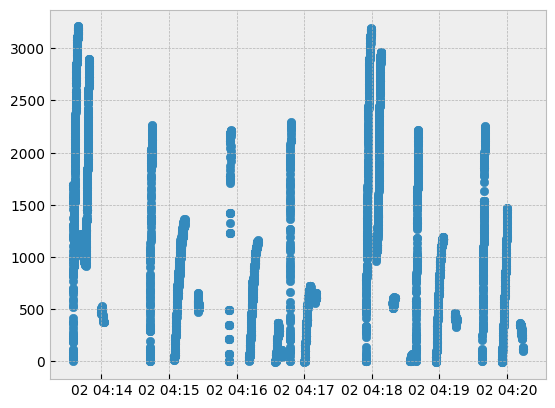

In [60]:
carlog = pd.read_csv('parseddata0005CSV_run_1.csv', index_col='Time', parse_dates=['Time'])
print(list(carlog))
carlog=carlog[['D1_Commanded_Torque','D2_Torque_Feedback','D2_Motor_Speed','D1_DC_Bus_Voltage','D4_DC_Bus_Current']]
print(list(carlog))
plt.scatter(carlog.index,carlog['D2_Motor_Speed'])

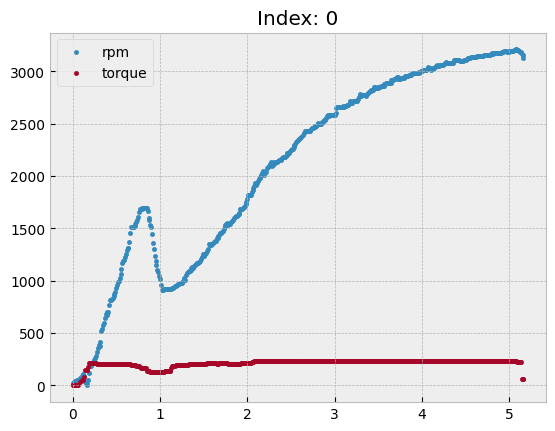

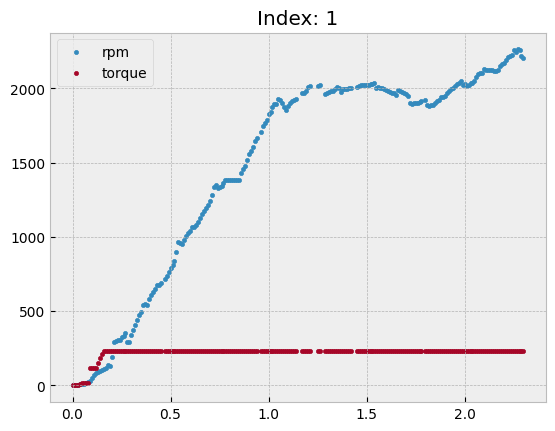

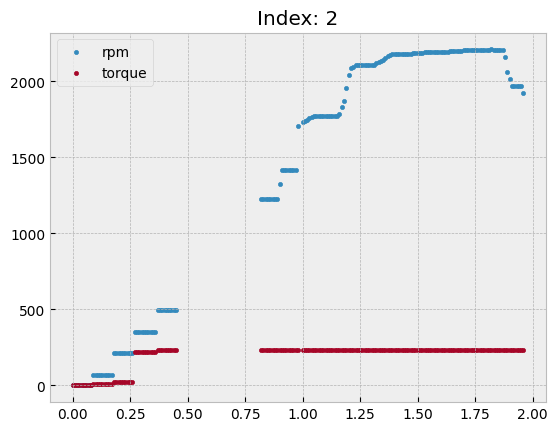

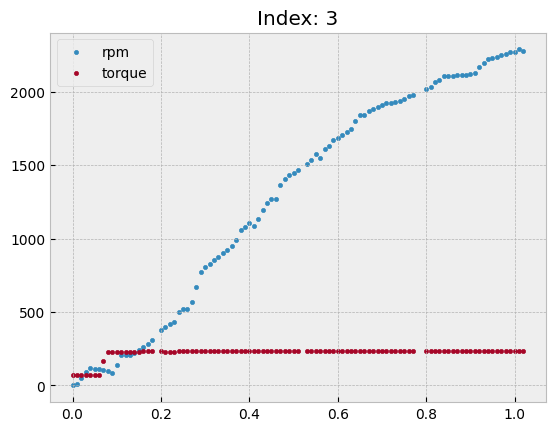

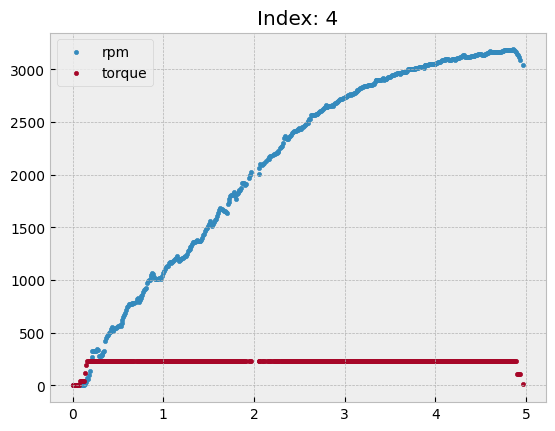

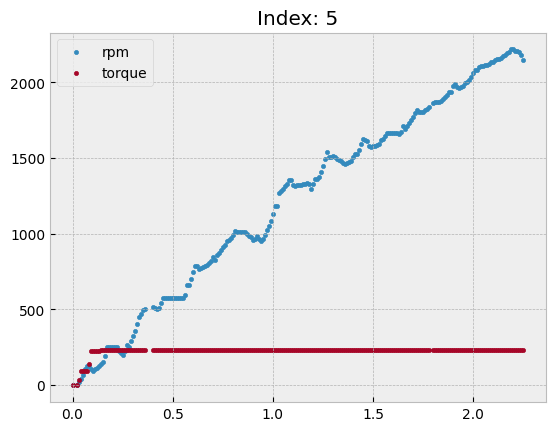

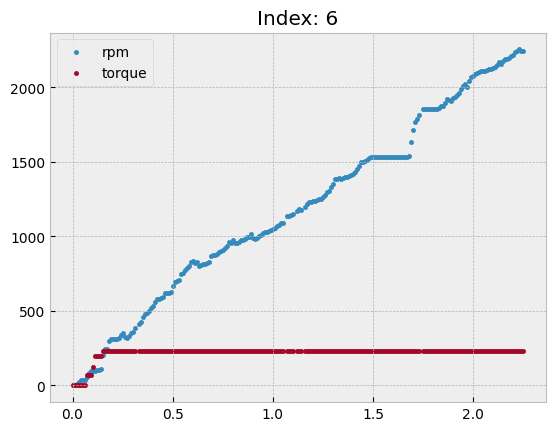

In [61]:
runs_dfs = []
carlog['time_groups'] = (
    carlog.index.to_series().diff().dt.seconds > 1).cumsum()

for ct, data in carlog.groupby('time_groups'):
    if data['D1_Commanded_Torque'].max() < 200:
        continue
    if data['D2_Motor_Speed'].min() > 500:
        continue
    data['AbsoluteTime'] = (data.index - data.index.min()).total_seconds()
    data.set_index('AbsoluteTime', inplace=True)

    runs_dfs.append(data)
for index,run_data in enumerate(runs_dfs):
    plt.scatter(run_data.index,run_data['D2_Motor_Speed'],marker='.',label='rpm')
    plt.scatter(run_data.index,run_data['D1_Commanded_Torque'],marker='.',label='torque')
    plt.title(f"Index: {index}")
    plt.legend()
    plt.show()

ENERGUS72s8p 72S 8P, 20.0Ah, Max 302.40V, Nominal 259.2V


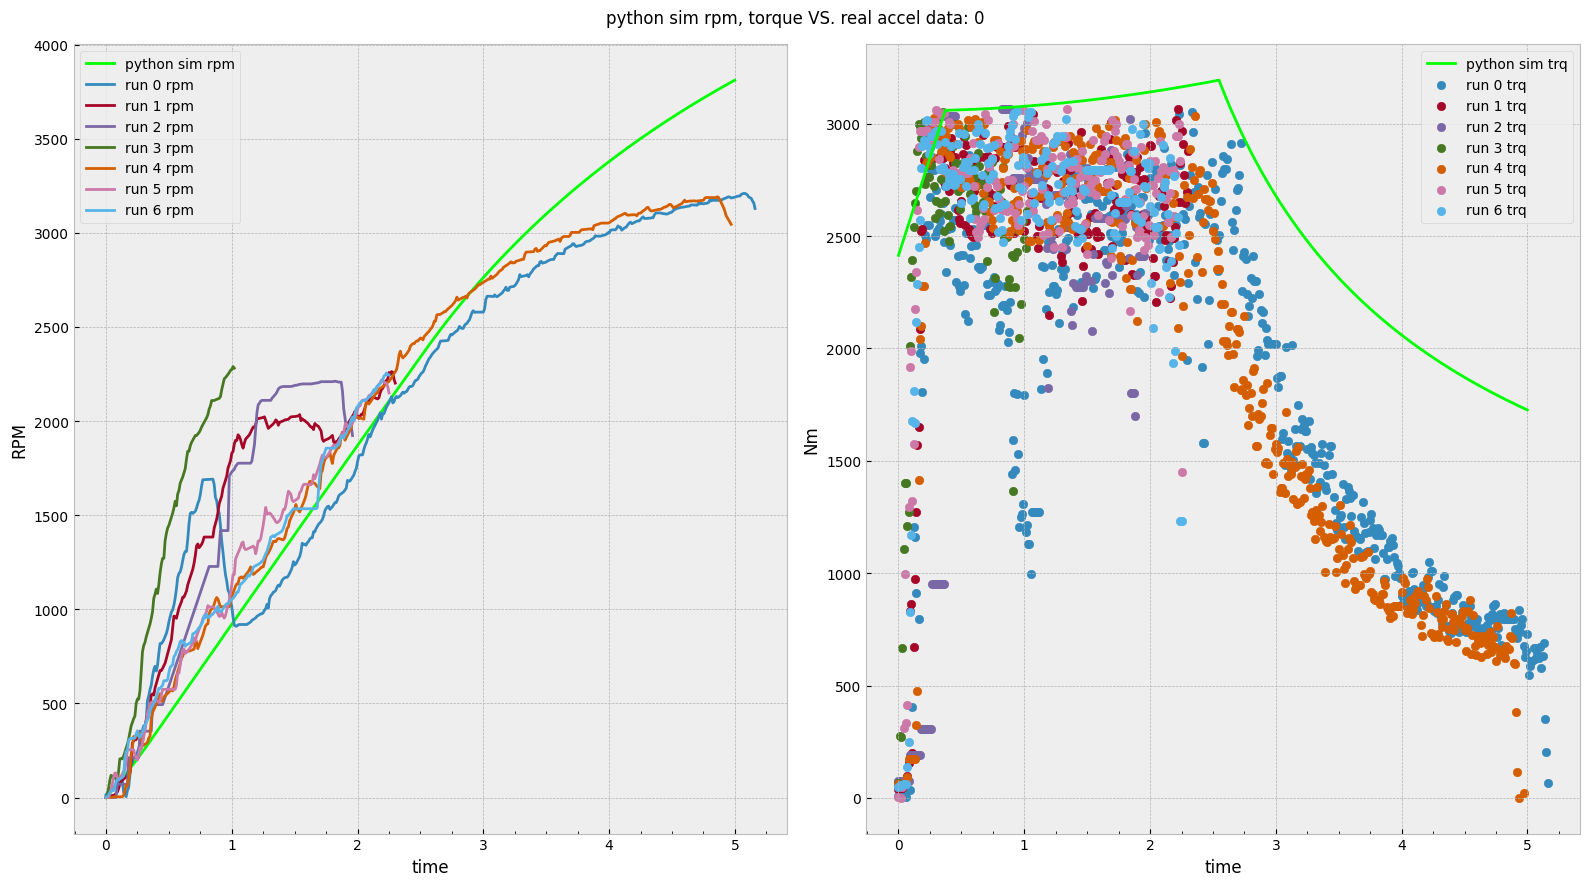

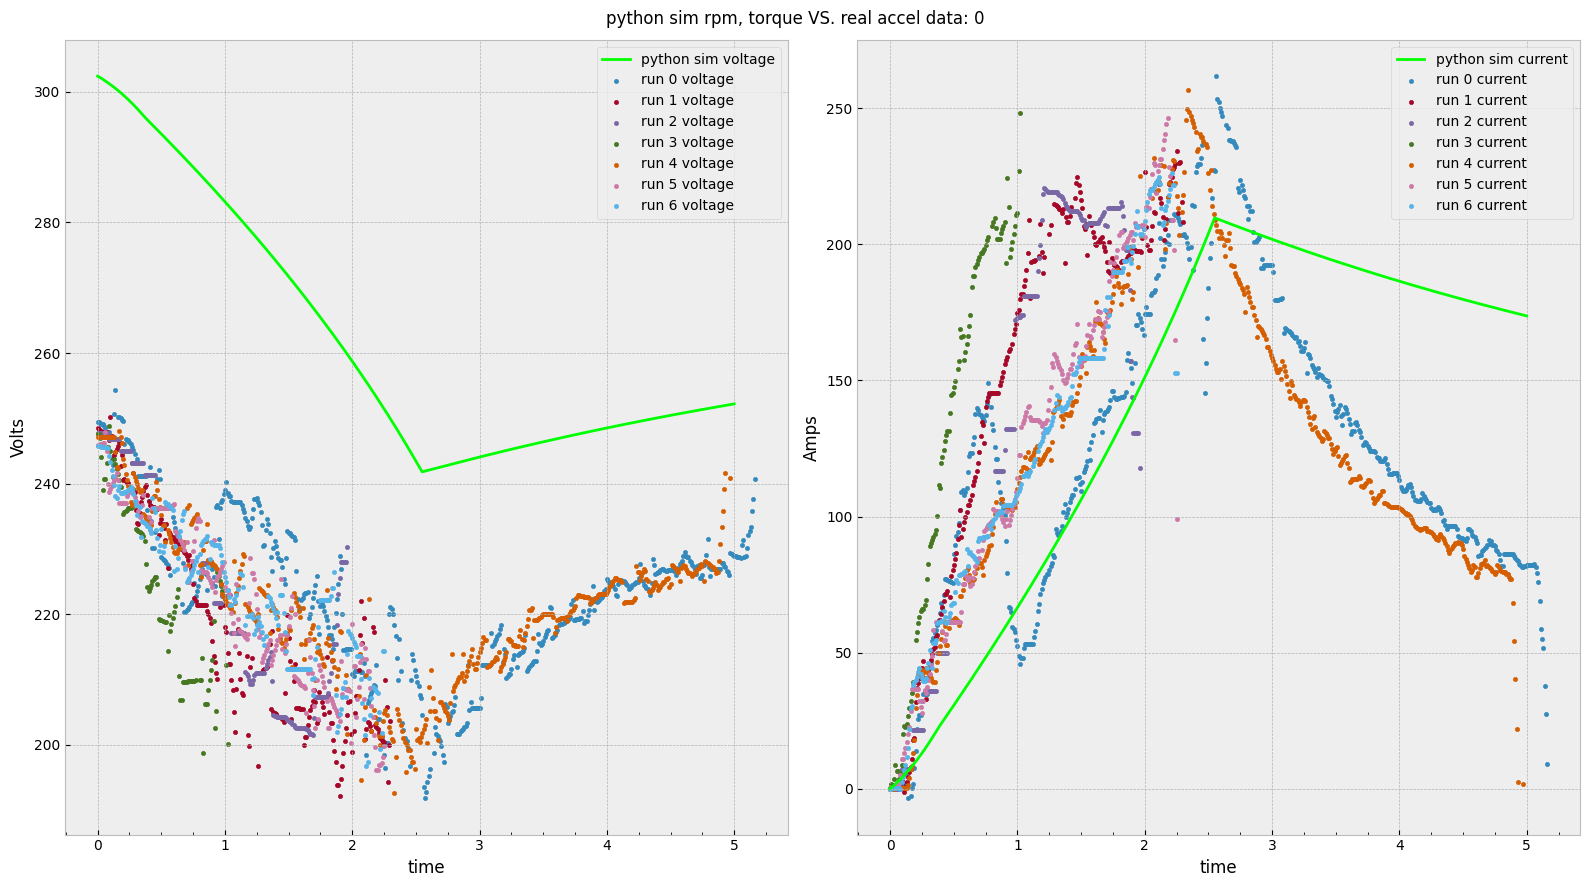

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
ax1.plot(t,motorrpm,label='python sim rpm',color='lime')
for index,run_data in enumerate(runs_dfs):
    ax1.plot(run_data.index,run_data['D2_Motor_Speed'],label=f'run {index} rpm')
ax1.legend()
ax1.set_ylabel('RPM')

ax2.plot(t,motortrq*4.2/.229,label='python sim trq',color='lime')
for index,run_data in enumerate(runs_dfs):
    ax2.scatter(run_data.index,run_data['D2_Torque_Feedback']*3/.229,label=f'run {index} trq')
ax2.legend()
ax2.set_ylabel('Nm')
for axis in fig.get_axes():
    axis.xaxis.set_minor_locator(ticker.MultipleLocator(.25))
    axis.set_xlabel('time')
plt.suptitle(f"python sim rpm, torque VS. real accel data: {df.index.min()}")
plt.tight_layout()
print(solver.accumulator)
plt.show()
# plt.plot(t,voltage)
# for index,run_data in enumerate(runs_dfs):
#     plt.scatter(run_data.index,run_data['D1_DC_Bus_Voltage'],marker='.')
# plt.show()
# plt.plot(t,current)
# for index,run_data in enumerate(runs_dfs):
#     plt.scatter(run_data.index,run_data['D4_DC_Bus_Current'],marker='.')
# plt.show()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
ax1.plot(t,voltage,label='python sim voltage',color='lime')
for index,run_data in enumerate(runs_dfs):
    ax1.scatter(run_data.index,run_data['D1_DC_Bus_Voltage'],label=f'run {index} voltage',marker='.')
ax1.legend()
ax1.set_ylabel('Volts')
ax2.plot(t,current,label='python sim current',color='lime')
for index,run_data in enumerate(runs_dfs):
    ax2.scatter(run_data.index,run_data['D4_DC_Bus_Current'],marker='.',label=f'run {index} current')
ax2.legend()
ax2.set_ylabel('Amps')
for axis in fig.get_axes():
    axis.xaxis.set_minor_locator(ticker.MultipleLocator(.25))
    axis.set_xlabel('time')
plt.suptitle(f"python sim rpm, torque VS. real accel data: {df.index.min()}")
plt.tight_layout()
plt.show()